# Natural Language Processing - Text Classification example

###### Links: [News dataset (Kaggle)](https://www.kaggle.com/rmisra/news-category-dataset)  |  [Article on this use case ()]()

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")
from nlp_utils import *

###### Import data

In [2]:
import json

lst_dics = []
with open('data.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
    
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [3]:
dtf = pd.DataFrame(lst_dics)
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
dtf = dtf.rename(columns={"category":"y", "headline":"text"})

In [17]:
dtf.sample(5)

,y,text
49890,TECH,Cincinnati Zoo Deletes Social Media Accounts U...
75582,ENTERTAINMENT,"Yes, Gwen Stefani Thinks Blake Shelton Is Hot"
93630,POLITICS,Poll Shows Good News For Clinton
31466,POLITICS,Obamacare vs. Trumpcare: A Public Health Dilemma
11004,POLITICS,The GOP's Extremist Agenda Is Making It Easy F...


In [4]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
y       50879 non-null object
text    50879 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


### 1 - Text Analysis

###### Look for Metadata
- language detection
- named-entities recognition
- text cleaning
- length analysis
- sentiment analysis
- word frequency
- topic modeling

###### Target Variable

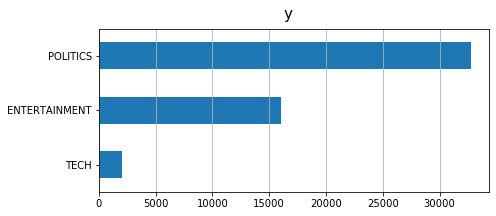

In [4]:
utils_plot_distributions(dtf, x="y", top=None, figsize=(7,3))

In [5]:
# Imbalanced

###### Language Detection

In [6]:
# this takes a while
dtf = add_detect_lang(dtf, "text")
dtf.head()

,y,text,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en


In [7]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["lang"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  en


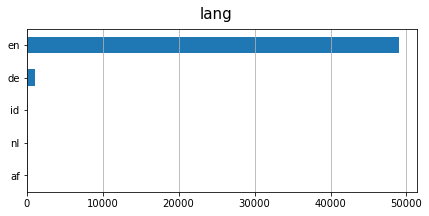

In [8]:
utils_plot_distributions(dtf, x="lang", top=5, figsize=(7,3))

In [9]:
# filter english only
dtf = dtf[dtf["lang"]=="en"]

###### Named-Entity Recognition

In [10]:
ner = spacy.load("en_core_web_lg")

In [11]:
lst_tag_type = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]

In [12]:
ner_displacy(dtf["text"].iloc[0], ner, lst_tag_type, title="NER example")

In [13]:
# example of replacing text and tags extraction
utils_ner_text(dtf["text"].iloc[0], ner, lst_tag_type, grams_join="_")

("Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song",
 [('Will Smith', 'PERSON'),
  ('Diplo', 'PERSON'),
  ('Nicky Jam', 'PERSON'),
  ("The 2018 World Cup's", 'EVENT')])

In [14]:
# this takes a while
dtf = add_ner_spacy(dtf, "text", ner, lst_tag_type, grams_join="_", create_features=True)
dtf.head()

--- tagging ---
--- counting tags ---
--- creating features ---


,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,tags_NORP,tags_LOC,tags_PRODUCT,tags_ORG
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,1,3,0,0,0,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,0,1,0,0,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,0,2,1,0,0,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,0,1,0,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,0,0,0,1


In [15]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_tagged"].iloc[i])
print("tags:")
dtf["tags"].iloc[i]

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song
tags:


[{('Will Smith', 'PERSON'): 1},
 {('Diplo', 'PERSON'): 1},
 {('Nicky Jam', 'PERSON'): 1},
 {("The 2018 World Cup's", 'EVENT'): 1}]

# ENTERTAINMENT:


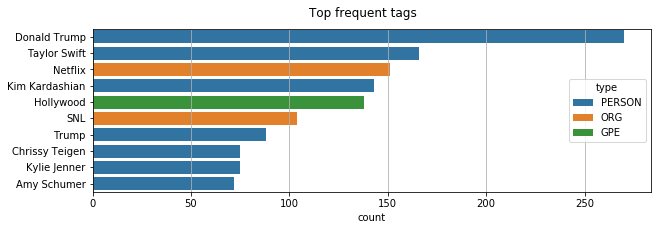

# POLITICS:


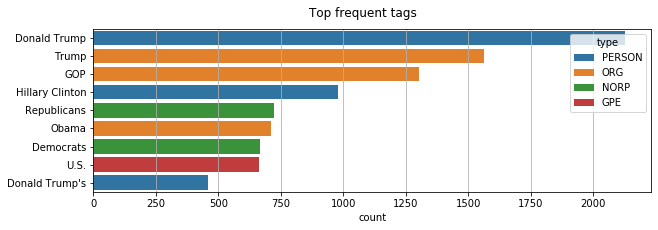

# TECH:


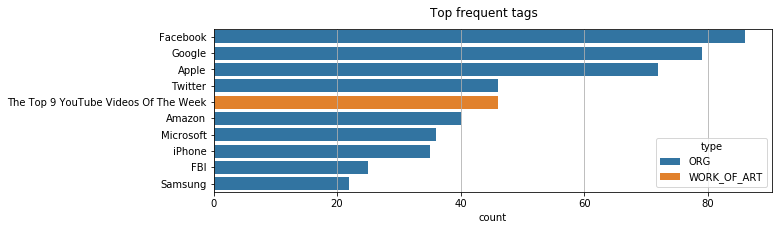

In [16]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    common_tags = tags_freq(tags=dtf[dtf["y"]==y]["tags"], top=10, figsize=(10,3))

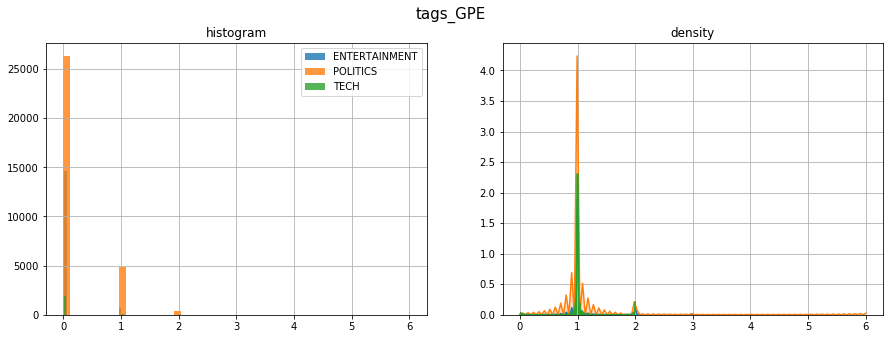

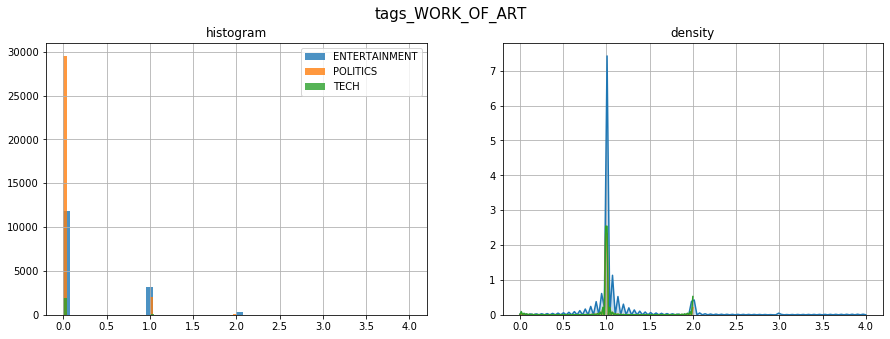

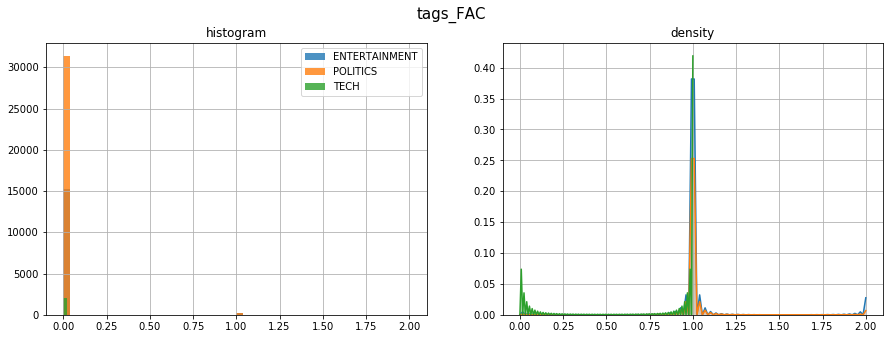

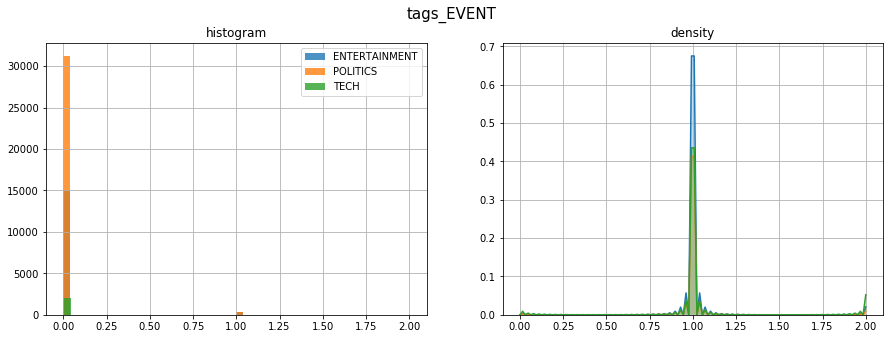

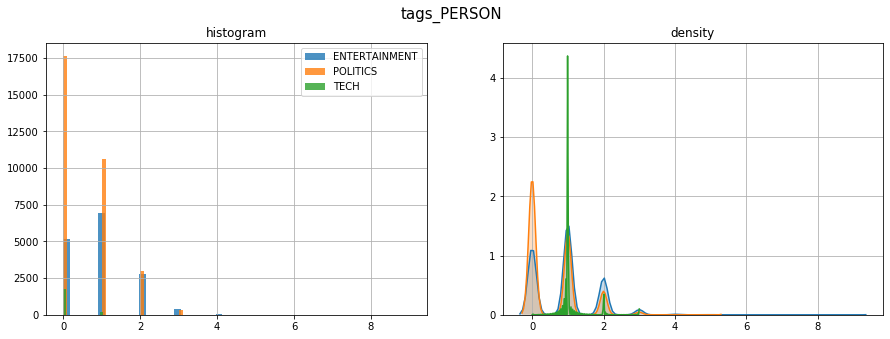

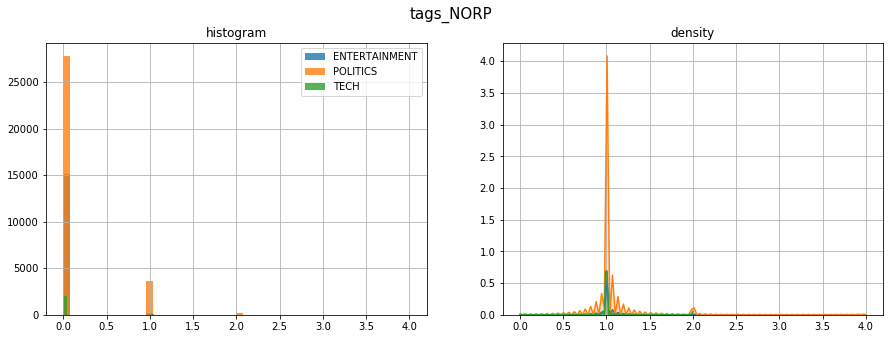

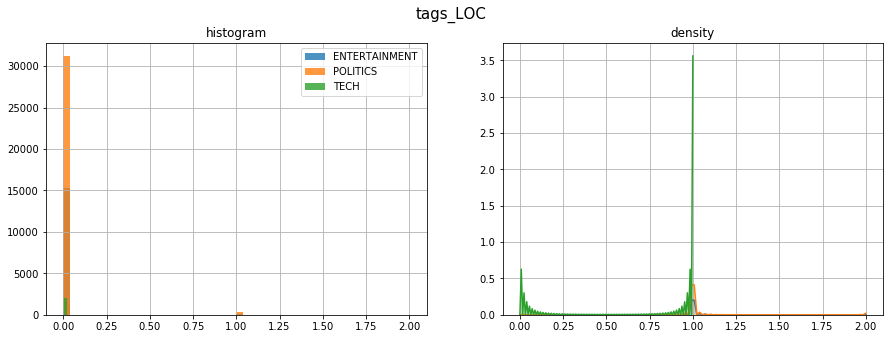

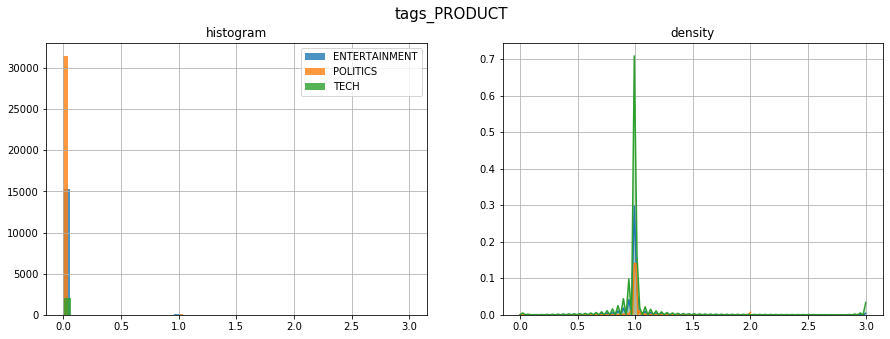

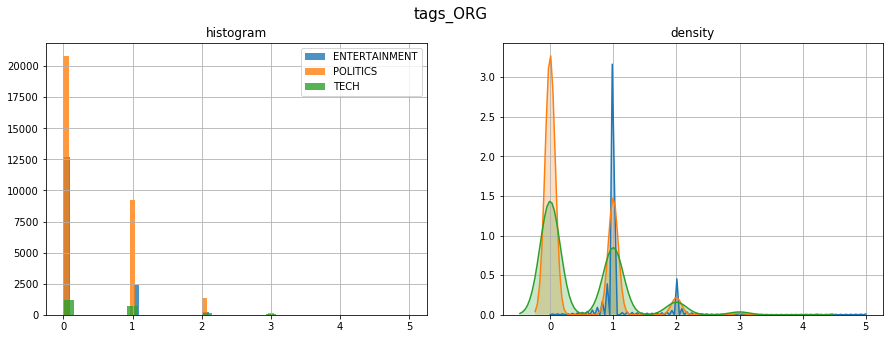

In [17]:
# tags bivariate distribution
for x in dtf.filter(like="tags_", axis=1).columns:
    utils_plot_distributions(dtf, x=x, y="y", bins=None, figsize=(15,5))

###### Text Cleaning

In [18]:
# example
i = 0
print("--- original ---")
print(dtf["text"].iloc[i])

print("--- cleaning ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=None, flg_stemm=False, flg_lemm=True))

print("--- tokenization ---")
print(dtf["text"].iloc[i].split())

print("--- remove stopwords ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=set(nltk.corpus.stopwords.words("english")), 
                      flg_stemm=False, flg_lemm=None))

print("--- stemming ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=set(nltk.corpus.stopwords.words("english")), 
                      flg_stemm=True, flg_lemm=False))

print("--- lemmatisation ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=set(nltk.corpus.stopwords.words("english")), 
                      flg_stemm=False, flg_lemm=True))

--- original ---
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
--- cleaning ---
will smith join diplo and nicky jam for the 2018 world cup official song
--- tokenization ---
['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', "Cup's", 'Official', 'Song']
--- remove stopwords ---
smith joins diplo nicky jam 2018 world cups official song
--- stemming ---
smith join diplo nicki jam 2018 world cup offici song
--- lemmatisation ---
smith join diplo nicky jam 2018 world cup official song


In [19]:
# create stopwords
lst_stopwords = create_stopwords(["english"], 
                                 lst_new_words=["dtype","say","new","length","object","u","ha","wa"])

In [20]:
## preprocess text
dtf = add_preprocessed_text(dtf, "text", lst_regex=None, lst_stopwords=lst_stopwords, flg_stemm=False, flg_lemm=True)
dtf.head()

--- found NAs ---
                               text text_clean
10904                      What If?           
31850   This Is Us Is For All Of Us           
92381             WHO Are You Now ?           
121299                 So Now What?           


,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,tags_NORP,tags_LOC,tags_PRODUCT,tags_ORG,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,1,3,0,0,0,0,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,0,1,0,0,0,0,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,0,2,1,0,0,0,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,0,1,0,0,0,0,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,0,0,0,1,morgan freeman devastated sexual harassment cl...


In [21]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_clean"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
smith join diplo nicky jam 2018 world cup official song


###### Length Analysis

In [22]:
dtf = add_text_length(dtf, "text_clean")
dtf.head()

                     min       mean    max
word_count           1.0   7.336369   36.0
char_count           4.0  43.461752  214.0
sentence_count       1.0   1.000000    1.0
avg_word_length      2.5   5.970404   15.0
avg_sentence_lenght  1.0   7.336369   36.0


,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,tags_NORP,tags_LOC,tags_PRODUCT,tags_ORG,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,1,3,0,0,0,0,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,0,1,0,0,0,0,hugh grant marries first time age 57,7,30,1,4.285714,7.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,0,2,1,0,0,0,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,0,1,0,0,0,0,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,0,0,0,1,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0


In [23]:
# check
i = 0
print(dtf["text_clean"].iloc[i], " --> ")
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    print(col+":", dtf[col].iloc[i])

smith join diplo nicky jam 2018 world cup official song  --> 
word_count: 10
char_count: 46
sentence_count: 1
avg_word_length: 4.6
avg_sentence_lenght: 10.0


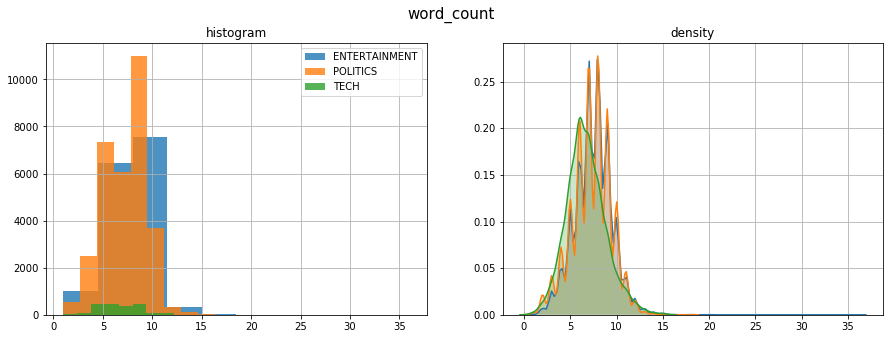

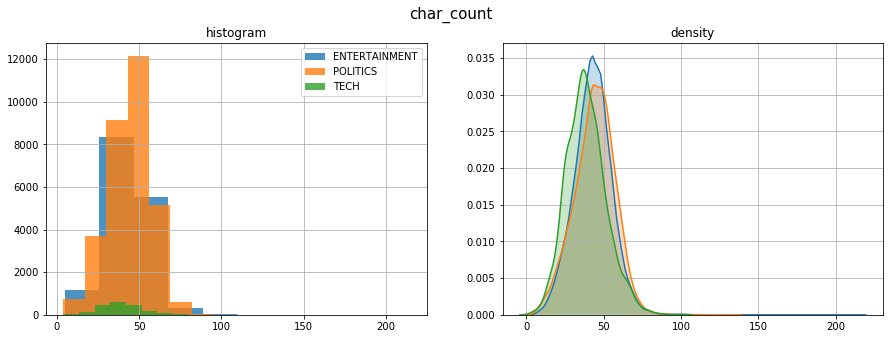

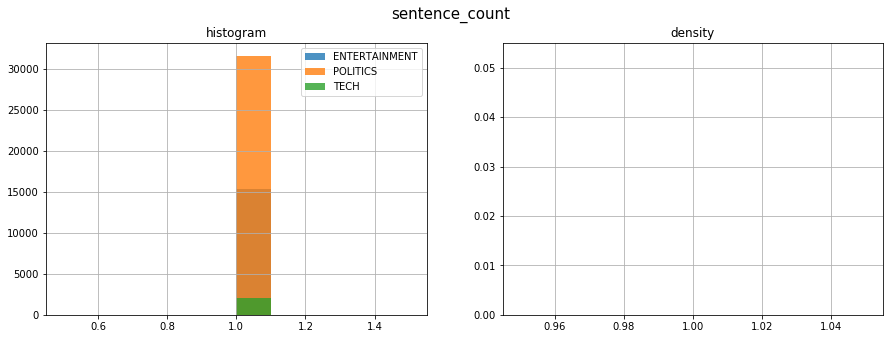

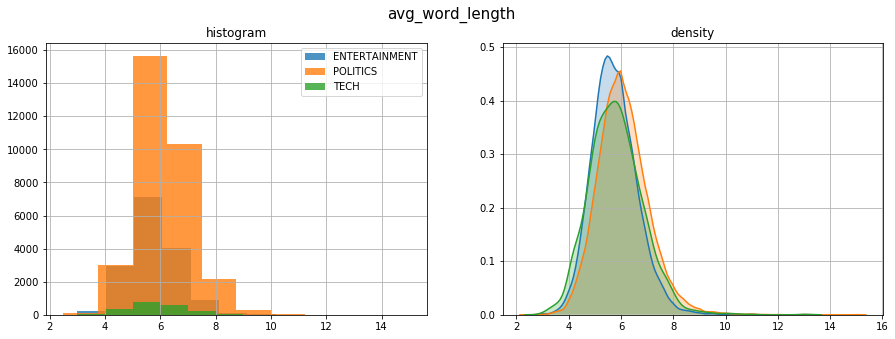

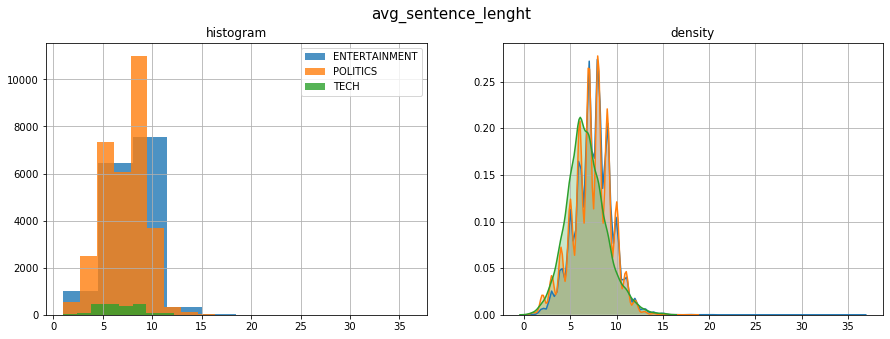

In [24]:
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    utils_plot_distributions(dtf, x=col, y="y", bins=10, figsize=(15,5))

###### Sentiment Analysis

In [25]:
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(-1,1))
dtf.head()

             count      mean       std  min  25%  50%    75%  max
sentiment  48970.0  0.038761  0.261755 -1.0  0.0  0.0  0.025  1.0


,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,...,tags_LOC,tags_PRODUCT,tags_ORG,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,1,3,...,0,0,0,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0,0.00
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,0,1,...,0,0,0,hugh grant marries first time age 57,7,30,1,4.285714,7.0,0.25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,0,2,...,0,0,0,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0,0.00
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,0,1,...,0,0,0,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0,0.00
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,0,0,1,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0,0.50


In [26]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["sentiment"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  0.0


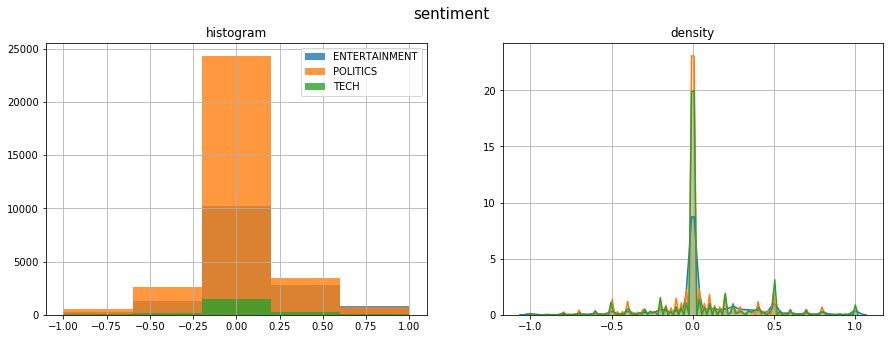

In [27]:
utils_plot_distributions(dtf, x="sentiment", y="y", bins=5, figsize=(15,5))

In [28]:
# I'll give a range of 0-1 to the sentiment
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(0,1))

             count     mean       std  min  25%  50%     75%  max
sentiment  48970.0  0.51938  0.130877  0.0  0.5  0.5  0.5125  1.0


###### Word frequency

# ENTERTAINMENT:


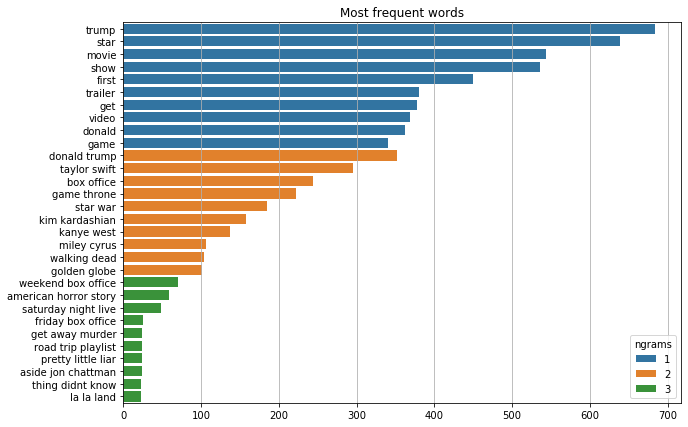

# POLITICS:


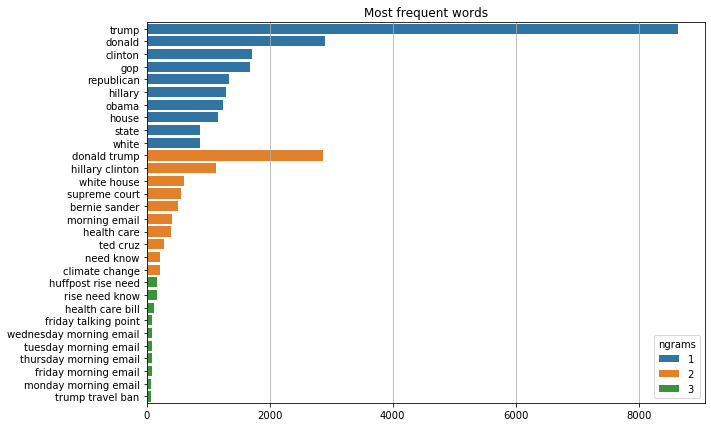

# TECH:


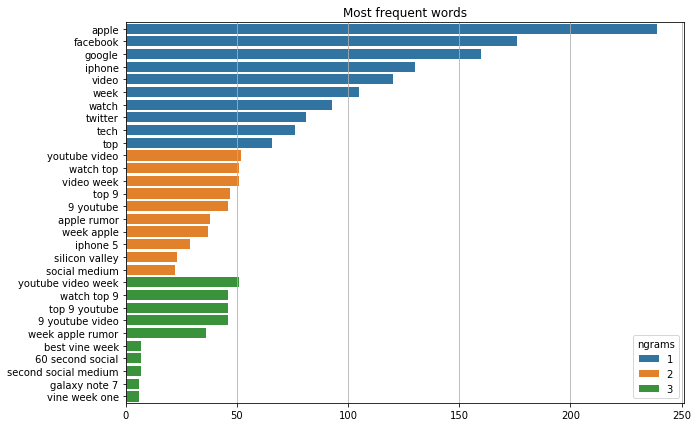

In [29]:
dtf_freq = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [292]:
dtf_freq.sample(5)

,word,freq,ngrams,y
68608,crime rent,1,2,ENTERTAINMENT
81664,lie talk gravedigger,1,3,POLITICS
148199,reach palestinian,1,2,POLITICS
85300,ouch home,1,2,ENTERTAINMENT
17778,51 million,2,2,POLITICS


# ENTERTAINMENT:


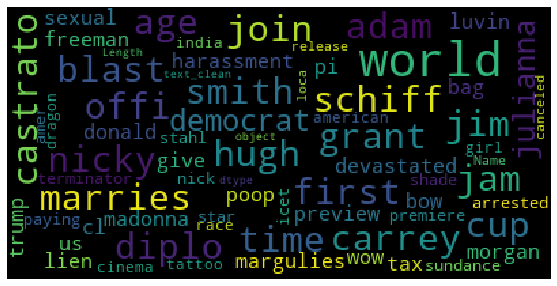

# POLITICS:


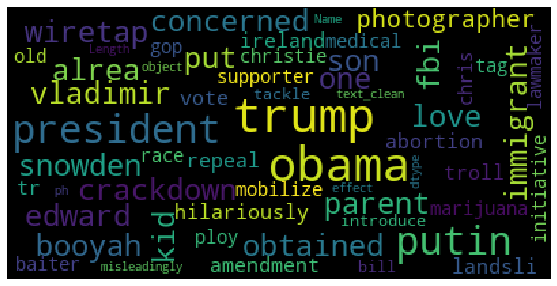

# TECH:


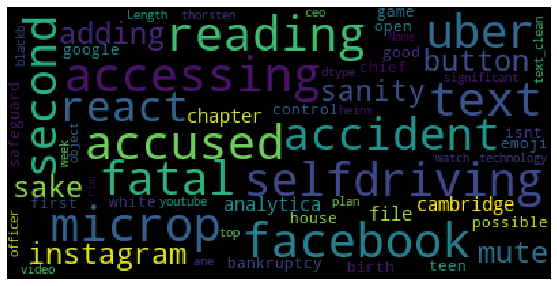

In [30]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=dtf[dtf["y"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

###### Topic modeling

# ENTERTAINMENT:
--- training ---
--- model fitted ---


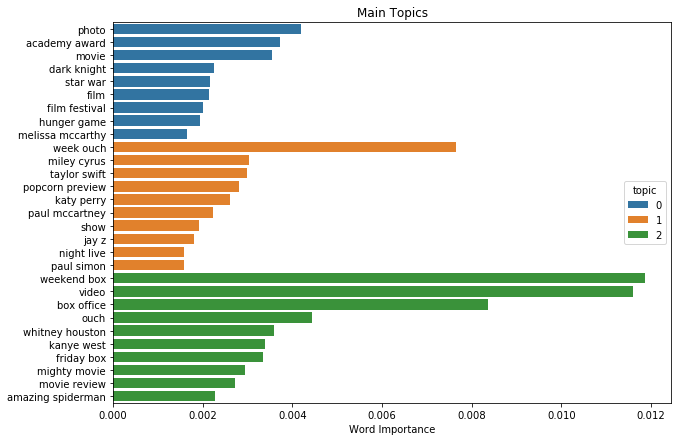

 
# POLITICS:
--- training ---
--- model fitted ---


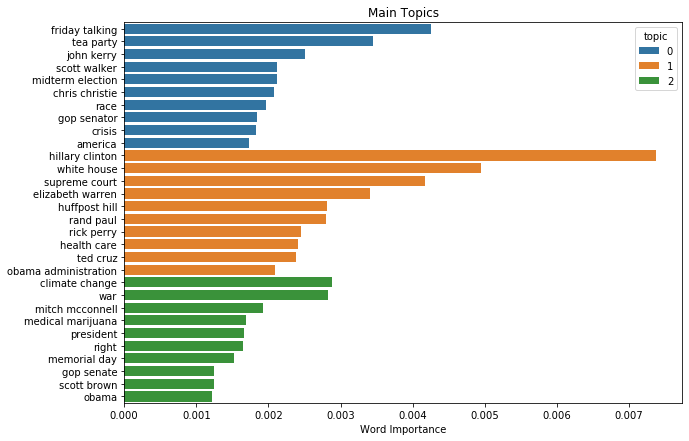

 
# TECH:
--- training ---
--- model fitted ---


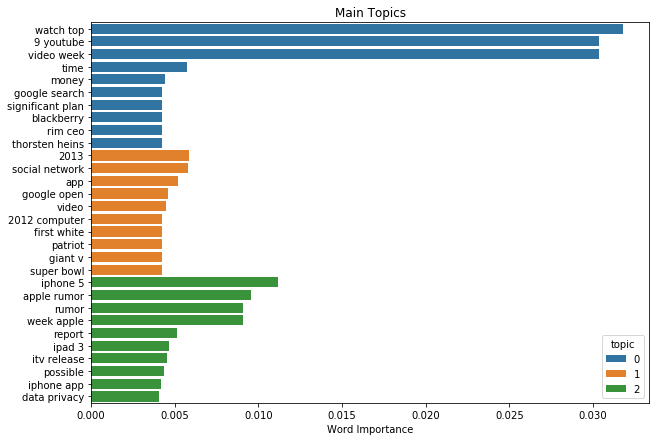

In [123]:
dtf_topics = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    lda, dtf_y = fit_lda(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=2, grams_join=" ", 
                         n_topics=3, n_words=5, plot=True, figsize=(10,7))
    dtf_y["y"] = y
    dtf_topics = dtf_topics.append(dtf_y)
    print(" ")

In [102]:
dtf_topics.sample(5)

,topic,id,word,weight,y
20,2,4036,week apple,0.009032,TECH
0,0,45,kanye west,0.003728,ENTERTAINMENT
23,2,3319,academy award,0.003384,ENTERTAINMENT
8,0,822,year,0.001860,ENTERTAINMENT
11,1,891,elizabeth warren,0.003308,POLITICS


###### Summary

In [32]:
# keeping all the features
dtf.head()

,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,...,tags_LOC,tags_PRODUCT,tags_ORG,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,1,3,...,0,0,0,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0,0.500
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,0,1,...,0,0,0,hugh grant marries first time age 57,7,30,1,4.285714,7.0,0.625
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,0,2,...,0,0,0,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0,0.500
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,0,1,...,0,0,0,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0,0.500
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,0,0,1,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0,0.750


### 2 - Preprocessing

###### Partitioning

In [33]:
dtf_train, dtf_test = dtf_partitioning(dtf, y="y", test_size=0.3, shuffle=False)

X_train shape: (34279, 20) | X_test shape: (14691, 20)
y:
  POLITICS  -->  train: 0.71 | test: 0.49
  ENTERTAINMENT  -->  train: 0.26 | test: 0.44
  TECH  -->  train: 0.03 | test: 0.07
21 features: ['text', 'lang', 'text_tagged', 'tags', 'tags_GPE', 'tags_WORK_OF_ART', 'tags_FAC', 'tags_EVENT', 'tags_PERSON', 'tags_NORP', 'tags_LOC', 'tags_PRODUCT', 'tags_ORG', 'text_clean', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_lenght', 'sentiment']


### 3 - Baseline (Bag-of-Words + Machine Learning)

###### Features Engineering

In [34]:
# count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [38]:
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vectorizer=vectorizer, vocabulary=None)

X_train, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

--- creating sparse matrix ---
shape: (34279, 10000)
--- creating vocabulary ---
len: 10000
--- tokenization ---
len: 34279


In [43]:
# check some features
f_range = (6000, 6005)

print("fetures name (from dic_vocabulary):")
print({k:v for k,v in sorted(dic_vocabulary.items(), key=lambda item:item[1], reverse=False)
      if v in np.arange(f_range[0], f_range[1]+1, step=1)})

print("")
print("value of these features (in the sparse matrix) for the first text:")
print(vectorizer.get_feature_names()[f_range[0]:f_range[1]])
print(X_train[0, f_range[0]:f_range[1]].todense())

fetures name (from dic_vocabulary):
{'nuclear option': 6000, 'nuclear war': 6001, 'nuclear weapon': 6002, 'nude': 6003, 'nude photo': 6004, 'nugent': 6005}

value of these features (in the sparse matrix) for the first text:
['nuclear option', 'nuclear war', 'nuclear weapon', 'nude', 'nude photo']
[[0. 0. 0. 0. 0.]]


In [44]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

## list of token ids: [[1, 2, 3], ...]
len_tokens = len(lst_text2tokens[i])
print("to: ", lst_text2tokens[i], "| len:", len(lst_text2tokens[i]))

## words not in vocabulary?
if len_txt-len_tokens != 0:
    missing_words = [word for word in dtf_train["text_clean"].iloc[i].split() if word not in dic_vocabulary.keys()]
    print("!!!", len_txt-len_tokens, "words not in vocabulary:", missing_words)

from:  smith join diplo nicky jam 2018 world cup official song | len: 10
check:  smith  -- idx in vocabulary --> 8020
to:  [8020, 4660, 4530, 60, 9884, 2134, 6080, 8074] | len: 8
!!! 2 words not in vocabulary: ['diplo', 'nicky']


###### Features Selection

In [47]:
dtf_selection = features_selection(X_train, dtf_train["y"], X_names=vectorizer.get_feature_names(), 
                                   top=None, print_top=5)

# ENTERTAINMENT:
  . actor
  . album
  . amy
  . award
  . beyoncé
 
# POLITICS:
  . actor
  . apple
  . award
  . celebrity
  . clinton
 
# TECH:
  . amazon
  . android
  . app
  . apple
  . apple fbi
 


In [49]:
dtf_selection.sample(5)

,feature,score,y
7294,rift,0.999644,TECH
8570,tease,0.999991,ENTERTAINMENT
6692,prime thats,0.972337,POLITICS
9287,tuesday,0.998829,ENTERTAINMENT
6340,pay tribute,0.999860,ENTERTAINMENT


In [50]:
X_names = dtf_selection["feature"].unique().tolist()

In [54]:
dtf_X_train = sparse2dtf(X_train, dic_vocabulary, X_names)
dtf_X_train.head()

,X_actor,X_album,X_amy,X_award,X_beyoncé,X_box office,X_celebrity,X_chrissy,X_clinton,X_dead,...,X_big problem,X_working,X_serial,X_dont want,X_without,X_city,X_swipe,X_cambridge,X_cambridge analytica,X_protestors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
dtf_train = pd.concat([dtf_train, dtf_X_train.set_index(dtf_train.index)], axis=1)

print(dtf_train.shape)
dtf_train.head(3)

(34279, 3153)


,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,...,X_big problem,X_working,X_serial,X_dont want,X_without,X_city,X_swipe,X_cambridge,X_cambridge analytica,X_protestors
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Preprocess Test

In [56]:
X_test = vectorizer.transform(dtf_test["text_clean"])
dtf_X_test = sparse2dtf(X_test, dic_vocabulary, X_names)

In [57]:
dtf_test = pd.concat([dtf_test, dtf_X_test.set_index(dtf_test.index)], axis=1)

print(dtf_test.shape)
dtf_test.head(3)

(14691, 3153)


,y,text,lang,text_tagged,tags,tags_GPE,tags_WORK_OF_ART,tags_FAC,tags_EVENT,tags_PERSON,...,X_big problem,X_working,X_serial,X_dont want,X_without,X_city,X_swipe,X_cambridge,X_cambridge analytica,X_protestors
76827,POLITICS,Texas Raids Planned Parenthood Offices Across ...,en,Texas_Raids_Planned_Parenthood_Offices_Across_...,[{('Texas Raids Planned Parenthood Offices Acr...,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76829,TECH,Senator Wonders If 'Pro-Botnet' Caucus Deraile...,en,Senator Wonders If 'Pro-Botnet' Caucus Deraile...,"[{('CISA', 'ORG'): 1}]",0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76831,ENTERTAINMENT,Mariah Carey Dresses Up 'Dem Babies' In Adorab...,en,Mariah_Carey Dresses Up 'Dem Babies' In Adorab...,"[{('Mariah Carey', 'PERSON'): 1}]",0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Train

In [66]:
X_train = dtf_train.drop(["y","text","text_clean","text_tagged","tags","lang"], axis=1).values
y_train = dtf_train["y"].values

X_test = dtf_test.drop(["y","text","text_clean","text_tagged","tags","lang"], axis=1).values
y_test = dtf_test["y"].values

In [67]:
classifier = naive_bayes.MultinomialNB()

In [68]:
model, predicted_prob, predicted = ml_text_classif(X_train, y_train, X_test, classifier)

###### Evaluate

Accuracy: 0.81
Auc: 0.91
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.93      0.75      0.83      6434
     POLITICS       0.74      0.97      0.84      7187
         TECH       0.94      0.06      0.12      1070

     accuracy                           0.81     14691
    macro avg       0.87      0.60      0.60     14691
 weighted avg       0.84      0.81      0.78     14691



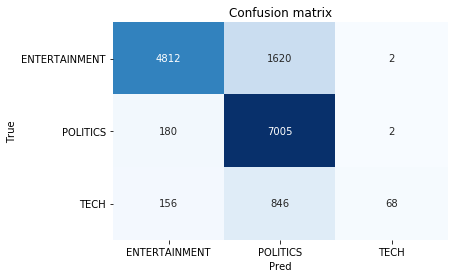

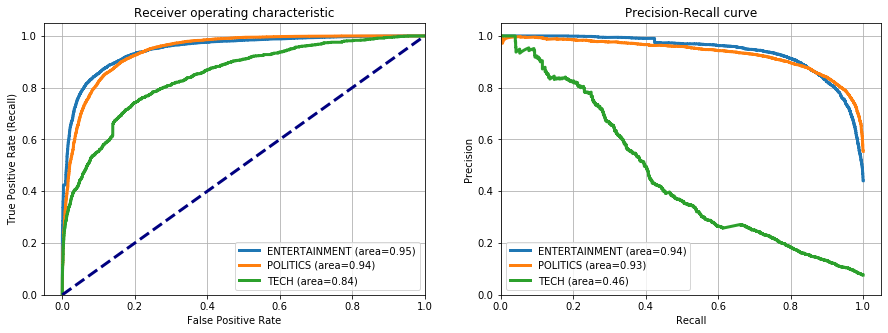

In [122]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

### 4 - Model Desing & Testing (pre-trained Embeddings + Deep Learning)

###### I already have:
- dtf_train --> x=text_clean, y must be encoded
- NB! I need a new vectorizer cuz the one in Baseline has ngrams=(1,2)

In [40]:
dtf_train, dic_y_mapping = encode_variable(dtf_train, "y")
print(dic_y_mapping)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}


###### Features Engineering

In [41]:
# create input for lstm (sequences of tokens)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=None, ngram_range=(1,1))

In [42]:
X_train, dic_vocabulary = text2seq(corpus=dtf_train["text_clean"], vectorizer=vectorizer)

--- creating sparse matrix ---
shape: (34267, 20623)
--- creating vocabulary ---
len: 20623
--- tokenization ---
len: 34267
--- padding to sequence ---
shape: (34267, 36)


In [43]:
print("from: ", dtf_train["text_clean"].iloc[0], "| len:", len(dtf_train["text_clean"].iloc[0].split()))
print("to: ", X_train[0], "| len:", len(X_train[0]))

from:  smith join diplo nicky jam 2018 world cup official song | len: 10
to:  [20623 20623 20623 20623 20623 20623 20623 20623 20623 20623 20623 20623
 20623 20623 20623 20623 20623 20623 20623 20623 20623 20623 20623 20623
 20623 20623 17085 10032  5432 12578  9874   203 20362  4684 12939 17231] | len: 36


In [44]:
# create weights for lstm (embeddings of tokens)
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [45]:
embeddings = vocabulary_embeddings(dic_vocabulary, nlp, dim_space=300)

shape:  (20624, 300)


In [46]:
word = dtf_train["text_clean"].iloc[0].split()[0]
print("word:", word)
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

word: smith
dic[word]: 17085 |idx
embeddings[idx]: (300,) |vector


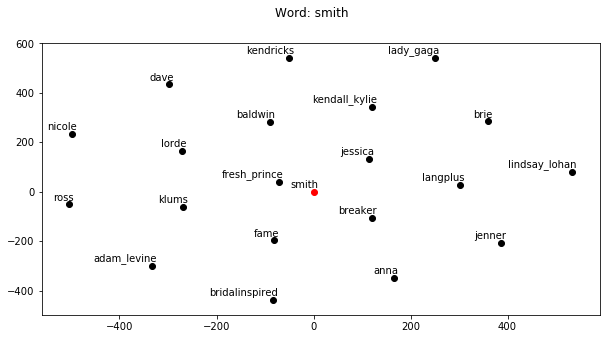

In [68]:
plot_w2v(nlp, plot_type="2d", word=word, top=20, figsize=(10,5))

###### Preprocess Test

In [48]:
X_test, _ = text2seq(corpus=dtf_test["text_clean"], vectorizer=vectorizer, vocabulary=dic_vocabulary, 
                     maxlen=X_train.shape[1])

--- creating sparse matrix ---
shape: (14686, 20623)
--- used vocabulary ---
len: 20623
--- tokenization ---
len: 14686
--- padding to sequence ---
shape: (14686, 36)


###### Train

In [49]:
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [ ]:
# LSTM with embeddings as weights
model = models.Sequential()
model.add( layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
                            input_length=X_train.shape[1], trainable=False) )
model.add( layers.LSTM(units=X_train.shape[1], dropout=0.2) )
model.add( layers.Dense(len(np.unique(y_train)), activation='softmax') )
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 300)           6187200   
_________________________________________________________________
lstm (LSTM)                  (None, 36)                48528     
_________________________________________________________________
dense (Dense)                (None, 3)                 111       
Total params: 6,235,839
Trainable params: 48,639
Non-trainable params: 6,187,200
_________________________________________________________________
None


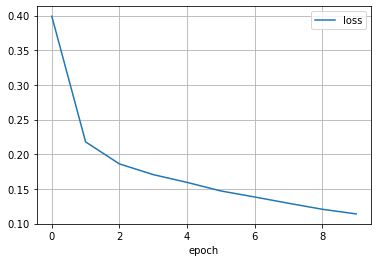

Check --> True: POLITICS Pred: POLITICS Prob: 0.9997187
Accuracy (overall correct predictions): 0.867
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.93      0.83      0.88      6435
     POLITICS       0.82      0.97      0.89      7184
         TECH       0.93      0.41      0.57      1067

     accuracy                           0.87     14686
    macro avg       0.89      0.74      0.78     14686
 weighted avg       0.88      0.87      0.86     14686



In [50]:
# this takes a while
model, predicted_prob, predicted = dl_text_classif(dic_y_mapping, X_train, y_train, X_test, model=model, 
                                                   epochs=10, batch_size=256)

###### Evaluate

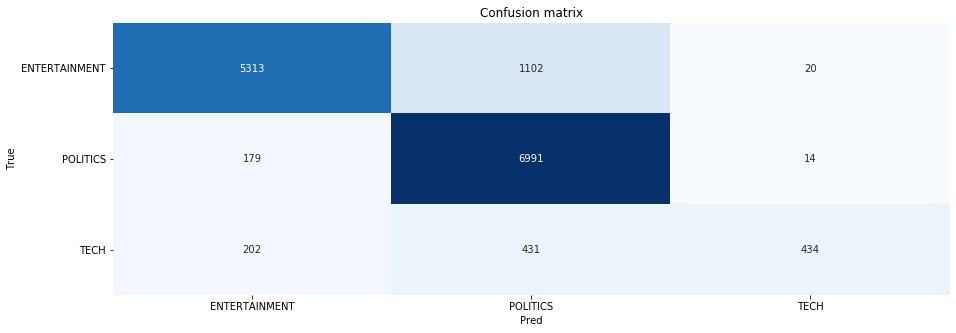

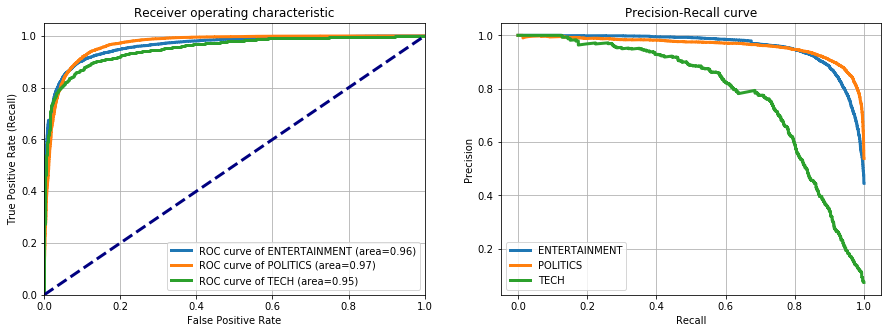

In [51]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

### 5 - Model Desing & Testing (training Embeddings from scratch + Deep Learning)

###### Plan:
- I will just create a new nlp model using all data
- create new Embeddings array with the new nlp model and the same vocabulary
- the rest of the process is the same as before

###### Train Word2Vec

In [52]:
np.max([len(text.split()) for text in dtf["text_clean"]]) /2 

18.0

In [53]:
lst_bigrams_stopwords = ["of","with","without","and","or","the","a"]

In [54]:
lst_corpus, nlp = fit_w2v(corpus=dtf["text_clean"], ngrams=1, min_count=1, size=300, window=18, sg=0, epochs=30, 
                          lst_bigrams_stopwords=lst_bigrams_stopwords)

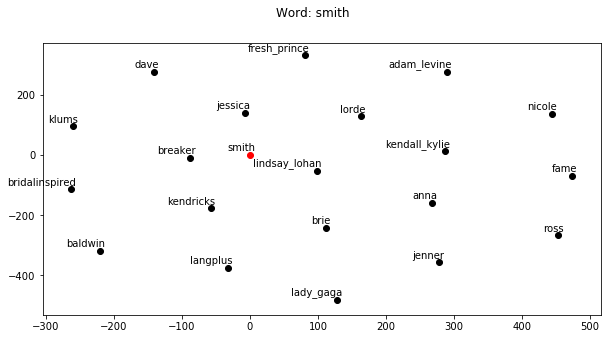

In [67]:
plot_w2v(nlp, plot_type="2d", word=word, top=20, figsize=(10,5))

In [56]:
embeddings = vocabulary_embeddings(dic_vocabulary, nlp, dim_space=300)

shape:  (20624, 300)


###### Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 300)           6187200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 36)                48528     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 111       
Total params: 6,235,839
Trainable params: 48,639
Non-trainable params: 6,187,200
_________________________________________________________________
None


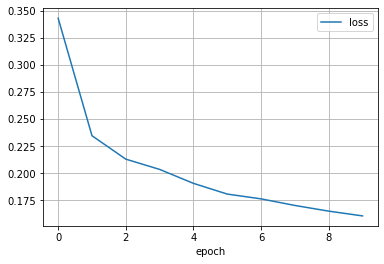

Check --> True: POLITICS Pred: POLITICS Prob: 0.9992223
Accuracy (overall correct predictions): 0.862
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.84      0.87      6435
     POLITICS       0.82      0.96      0.89      7184
         TECH       0.93      0.33      0.48      1067

     accuracy                           0.86     14686
    macro avg       0.89      0.71      0.75     14686
 weighted avg       0.87      0.86      0.85     14686



In [57]:
# this takes a while
model, predicted_prob, predicted = dl_text_classif(dic_y_mapping, X_train, y_train, X_test, embeddings=embeddings, 
                                                   epochs=10, batch_size=256)

###### Evaluate

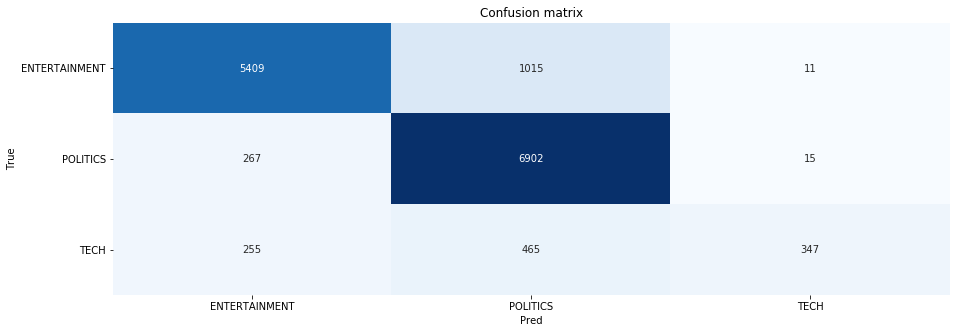

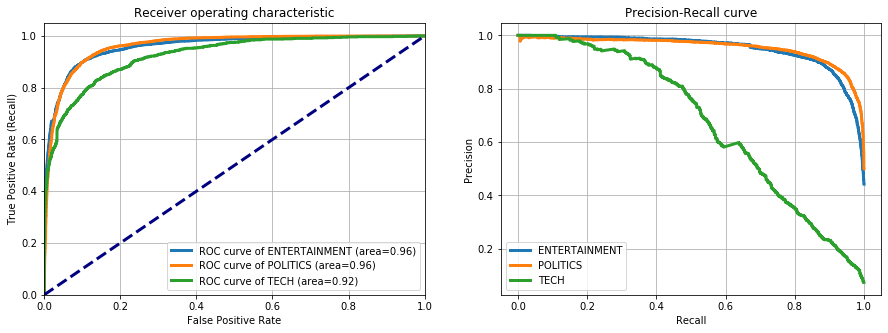

In [58]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

### 6 - Model Desing & Testing (Embedding + Clustering)

###### Plan:
- I will use the nlp model to create clusters for the classes
- then convert news into vectors and calculate distances

######  Create Clusters

In [59]:
# from the Baseline step
dic_clusters = {}
for y,lst_keywords in dic_features_selection.items():
    if y != "ALL":
        lst_grams = []
        for gram in lst_keywords:
            if len(gram.split())>1:
                lst_grams.append("_".join(gram.split()))
            else:
                lst_grams.append(gram)
        dic_clusters.update({y:lst_grams})

In [60]:
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...")

ENTERTAINMENT :  ['star', 'trump', 'trailer', 'movie', 'oscar'] ...
POLITICS :  ['trump', 'star', 'trailer', 'movie', 'season'] ...
TECH :  ['apple', 'facebook', 'google', 'iphone', 'tech'] ...


###### Fit PCA

In [61]:
pca = fit_pca_w2v(corpus=dtf_train["text_clean"], nlp=nlp)

X shape: (34267, 300)
pca shape: (34267, 300)


###### Predict Clusters

In [65]:
predicted_prob, predicted = predict_clusters_w2v(corpus=dtf_test["text_clean"], dic_clusters=dic_clusters, 
                                                 nlp=nlp, pca=None)

print("Accuracy (overall correct predictions):",  round(metrics.accuracy_score(y_test, predicted),3))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

--- embedding X and y ---
ENTERTAINMENT shape: (300,)
POLITICS shape: (300,)
TECH shape: (300,)
X shape: (14686, 300)
--- computing similarity ---
Accuracy (overall correct predictions): 0.531
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.89      0.72      0.80      6435
     POLITICS       0.64      0.33      0.43      7184
         TECH       0.14      0.74      0.23      1067

     accuracy                           0.53     14686
    macro avg       0.56      0.60      0.49     14686
 weighted avg       0.71      0.53      0.58     14686



###### Evaluate

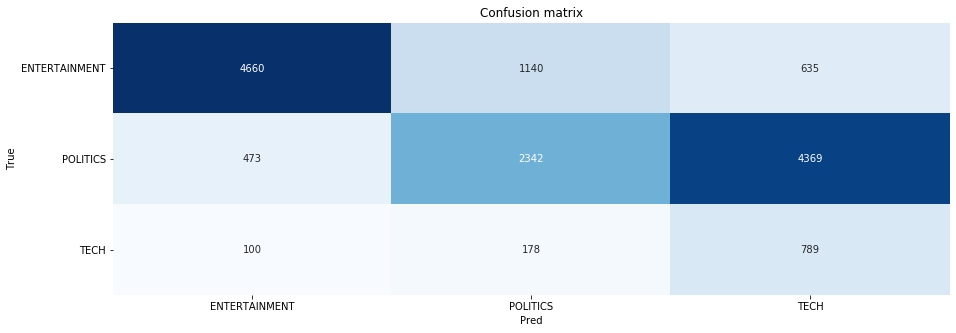

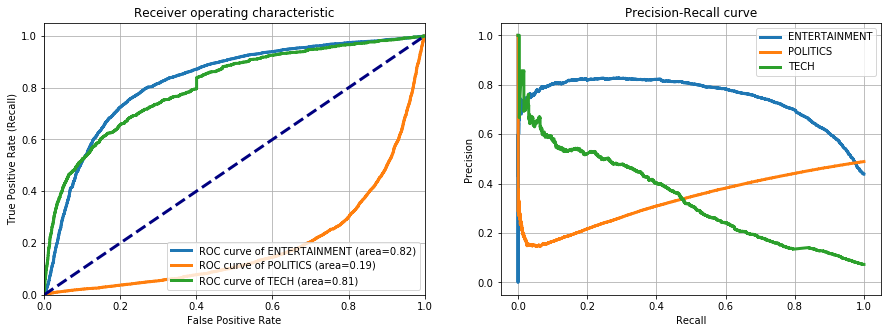

In [66]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))